# Initializing

In [92]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn model building & evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    make_scorer,
    recall_score,
    classification_report,
    confusion_matrix,
)

# Imbalanced-learn (resampling + pipelines)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score
import pandas as pd

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

In [22]:
# Initialize the dataframe
df = pd.read_csv('historical.csv')
df = df.drop(columns = ['tid'])
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,0.635636,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,-1.470780,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,-0.947894,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,0.080683,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,-1.054033,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0


# EDA

Our overall goal in the EDA is to guide the choice of preprocessing techniques. To do this, we will examine the extent of class imbalance and look if there exist patterns that could easily distinguish fraudulent from non-fraudulent transactions.

## Univariate

Figure 1 shows a clear imbalance between non-fraud and fraud cases, with non-fraud being far more prevalent. This class imbalance needs to be addressed before modeling.

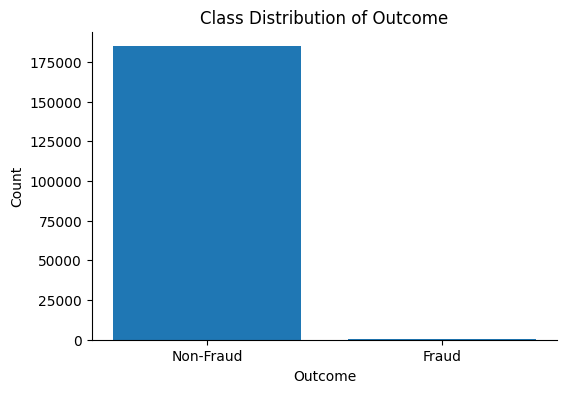

In [25]:
# Count values
class_counts = df["outcome"].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Class Distribution of Outcome")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

plt.show()


As shown in Figure 2, transaction amounts are highly right-skewed. When separated by outcome as done in Figure 3, fraudulent transactions have a lower median amount than non-fraudulent ones. However, when we look at the monetary value of the transactions, the top 25% of fraud cases account for over 88% of the total fraud value, showing that a small number of high-value cases drive most of the monetary risk.

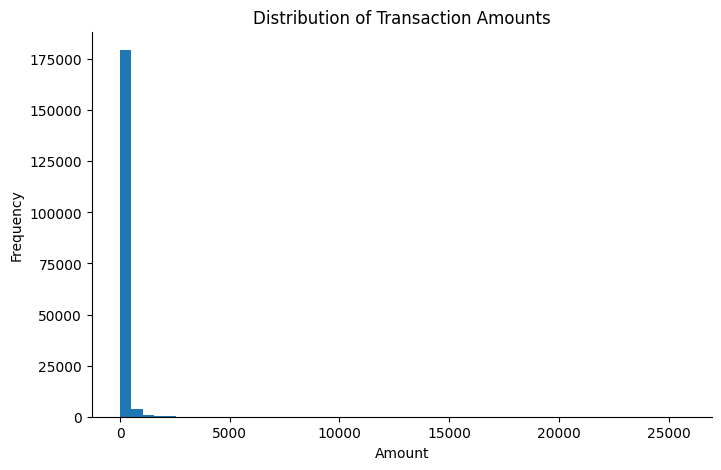

In [37]:
plt.figure(figsize=(8,5))
plt.hist(df["Amount"], bins=50)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

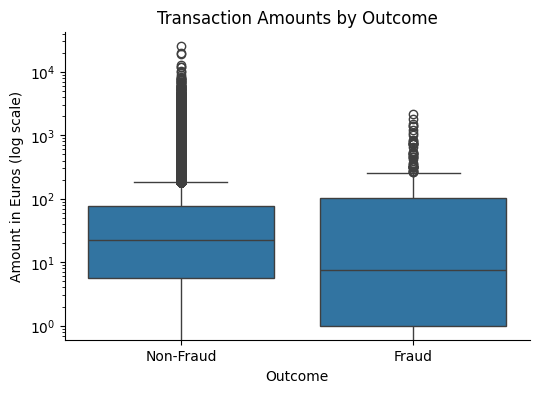

In [38]:
plt.figure(figsize=(6,4))

sns.boxplot(
    x="outcome",
    y="Amount",
    data=df
)
plt.yscale("log")  # handle skewness
plt.title("Transaction Amounts by Outcome")
plt.xlabel("Outcome")
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.ylabel("Amount in Euros (log scale)")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


## Bivariate

The correlation matrices in Figure 4 show little to no correlation among non-fraudulent transactions. In contrast, fraudulent transactions display strong correlations, which become evident when visualized on a heatmap. Thus, fraud data exhibits clearer patterns compared to non-fraud data.

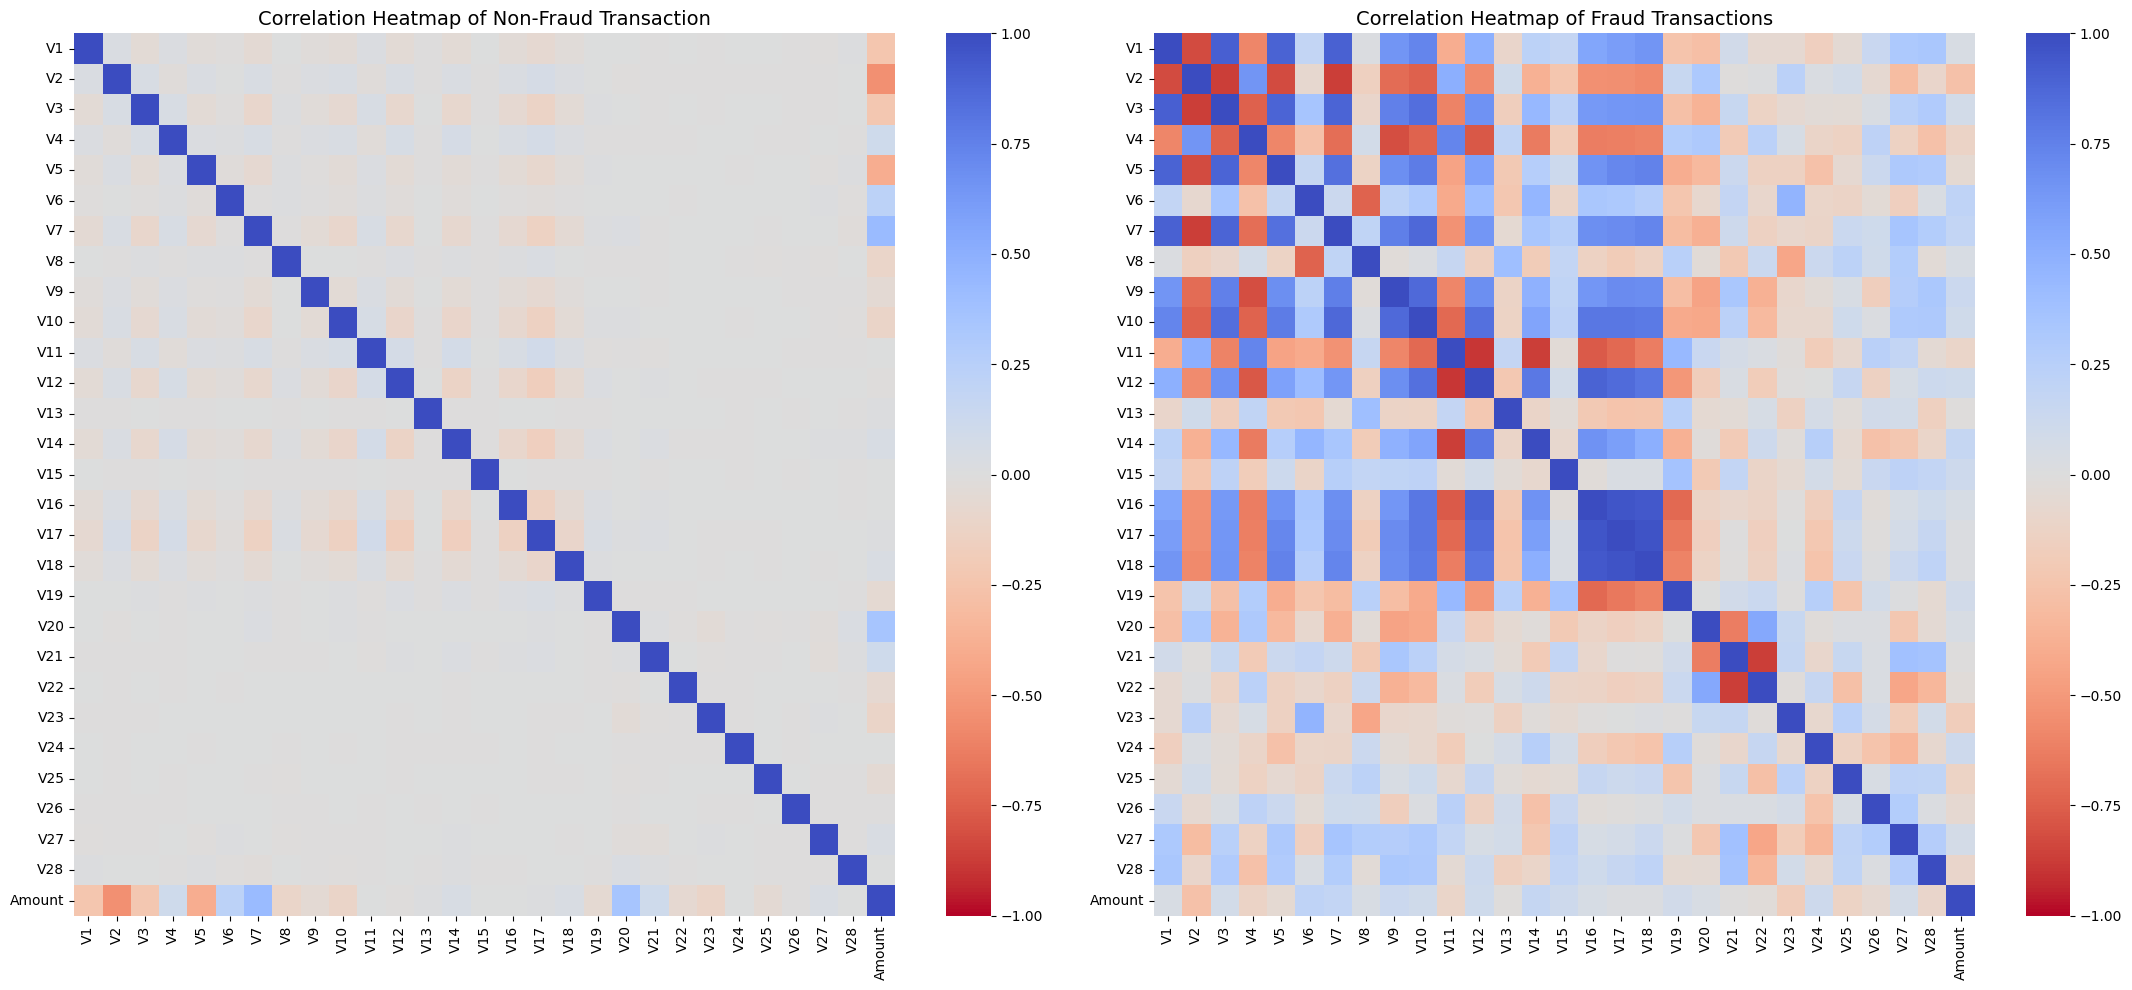

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split datasets
is_fraud = df["outcome"] == 1
df_0 = df[~is_fraud]
df_1 = df[is_fraud]

# Compute correlation matrices
corr_0 = df_0.iloc[:, :-1].corr()
corr_1 = df_1.iloc[:, :-1].corr()

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(
    corr_0,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[0]
)
axes[0].set_title("Correlation Heatmap of Non-Fraud Transaction", fontsize=14)

sns.heatmap(
    corr_1,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[1]
)
axes[1].set_title("Correlation Heatmap of Fraud Transactions", fontsize=14)

plt.tight_layout()
plt.show()

To further visualize the patterns in fraud data, two scatterplots were made in Figure 5 to show the relationships of V1 to V3 (a) and V18 to V16 (b). These plots further emphasizes how fraud transactions (red) cluster differently from non-fraud ones (blue), suggesting that certain components capture meaningful distinctions between the two classes.

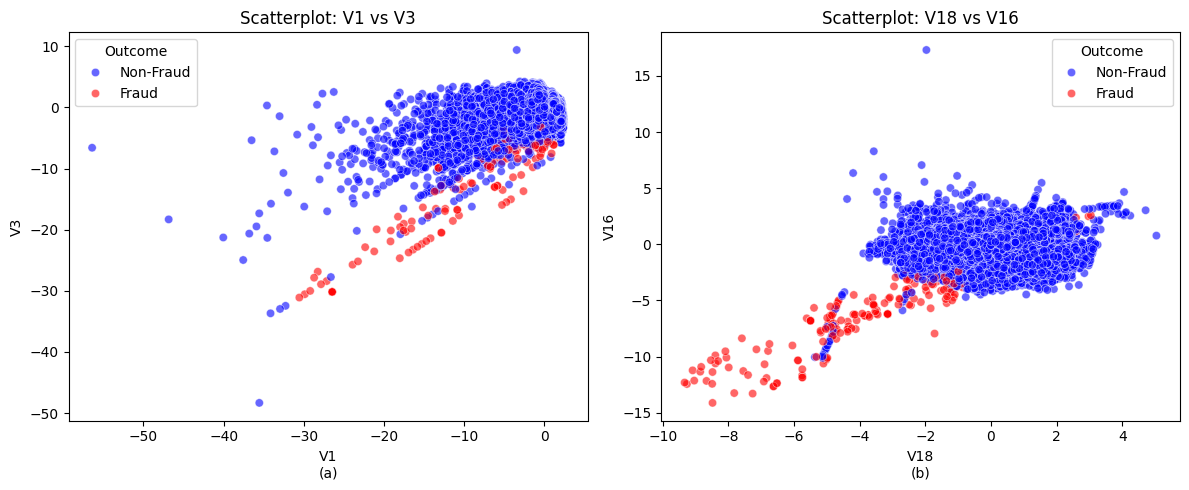

In [43]:
plt.figure(figsize=(12, 5))

# V1 vs V3
plt.subplot(1, 2, 1)
ax1 = sns.scatterplot(
    data=df,
    x="V1", y="V3",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
legend1 = ax1.legend_
legend1.set_title("Outcome")
for t, new_label in zip(legend1.texts, ["Non-Fraud", "Fraud"]):
    t.set_text(new_label)
plt.title("Scatterplot: V1 vs V3")
ax1.set_xlabel('V1\n(a)')

# V18 vs V16
plt.subplot(1, 2, 2)
ax2 = sns.scatterplot(
    data=df,
    x="V18", y="V16",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
legend2 = ax2.legend_
legend2.set_title("Outcome")
for t, new_label in zip(legend2.texts, ["Non-Fraud", "Fraud"]):
    t.set_text(new_label)
plt.title("Scatterplot: V18 vs V16")
ax2.set_xlabel('V18\n(b)')

plt.tight_layout()
plt.show()


# Data Preprocessing

No missing data were found, but duplicate entries were identified and removed. A total of 4,670 duplicates were dropped, leaving 97.4% of the data for analysis.

In [50]:
# Count of nulls over the whole dataframe
df.isnull().sum().sum()
# Get the deduplicated dataset
df_clean = df.drop_duplicates()

# Metrics

Given that our main goal is to determine the best strategy for handling class imbalance, we hold the model constant and use Random Forest as the baseline classifier. Let us now define the metrics that we shall use to optimize the model. We have:
1. Detection Rate
    * This asks, "Out of all transactions, how well does the model is at correctly identifying both fraud and non-fraud overall, where both are equally important?"

2. Fraud Capture Rate
    * This asks, "Out of all the fraud cases, how many did the model actually catch?"

3. Net Value Gained or Lost - 
    * This asks, "How much money does the model helps save (by catching fraud) versus how much is lost (from missing fraud or wrongly flagging legitimate transactions)?"

Because we use only one metric to optimize the model, we choose the Fraud Capture Rate to optimize since "CreditByte has long been plagued by credit card fraud." This metric best aligns with the business-critical objective of catching fraud. For business justification, we also report Net Value Gained/Lost alongside it to show the monetary consequences. Finally, we provide below the technical definition of each metric used:

1. **Detection Rate which is the same as Macro Recall**  
Detection Rate:  

$$
\text{Detection Rate} = \frac{1}{2} \bigg(\frac{TP_{\text{fraud}}}{TP_{\text{fraud}} + FN_{\text{fraud}}} + \frac{TP_{\text{nonfraud}}}{TP_{\text{nonfraud}} + FN_{\text{nonfraud}}} \bigg)
$$

where  
- $n_{\text{fraud}}$ = number of fraud samples  
- $n_{\text{nonfraud}}$ = number of non-fraud samples  
- $N$ = total number of samples  
- $TP_{\text{fraud}}$ = fraud cases correctly identified  
- $FN_{\text{fraud}}$ = fraud cases missed  
- $TP_{\text{nonfraud}}$ = non-fraud cases correctly identified  
- $FN_{\text{nonfraud}}$ = non-fraud cases missed  


2. **Fraud Capture Rate, which is the same as Recall for Fraud Transactions**  

$$
\text{Fraud Capture Rate} = \frac{TP_{\text{fraud}}}{TP_{\text{fraud}} + FN_{\text{fraud}}}
$$  

where  
- $TP_{\text{fraud}}$ = fraud cases correctly identified  
- $FN_{\text{fraud}}$ = fraud cases missed  


3. **Net Value Gained/Lost**  

$$
\text{Net Value} = V_{\text{caught}} - V_{\text{missed}} - V_{\text{false\_pos}}
$$  

where  
- $V_{\text{caught}}$ = total value of fraud correctly detected  
- $V_{\text{missed}}$ = total value of fraud not detected  
- $V_{\text{false\_pos}}$ = total value of non-fraud transactions falsely flagged  




# Actually Creating the Models

## Baseline

We set a baseline model to see how the data performs under different sampling strategies. For validation, we use a final hold-out set and apply k-fold cross-validation within the training data.

In [ ]:
# Do the great divide of train v hold-out set
target = df_clean['outcome']
X, y = df_clean.iloc[:, :-1], df_clean.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=target
)

# Just a sanity check
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X shape: {X.shape} = {X_train.shape[0] + X_test.shape[0]}")

X_train shape: (36090, 29)
X_test shape: (144364, 29)
X shape: (180454, 29) = 180454


In [93]:
# ---------------------------
# Define scorers
# ---------------------------

# FCR: recall for fraud class (positive class)
fcr_scorer = make_scorer(recall_score, pos_label=1)

# Detection: macro recall
detection_scorer = make_scorer(recall_score, average="macro")

# Net value scorer (needs X, y, estimator)
def net_value_scorer(estimator, X, y):
    # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    y_pred = estimator.predict(X)
    amount = X.iloc[:, -1]  # last column as transaction value
    caught_value = amount[(y == 1) & (y_pred == 1)].sum()
    missed_value = amount[(y == 1) & (y_pred == 0)].sum()
    false_positive_value = amount[(y == 0) & (y_pred == 1)].sum()
    return caught_value - missed_value - false_positive_value

scorers = {
    "fcr": fcr_scorer,
    "detection": detection_scorer,
    "net_value": net_value_scorer
}

# ---------------------------
# Optimization function
# ---------------------------
def optimize_sampler(x_train, y_train, sampler=None, k=5):
    """
    Optimizes Random Forest hyperparameters with optional sampler.
    
    Args:
        x_train (DataFrame): Features (last column must be transaction value)
        y_train (Series): Target (fraud = 1)
        sampler (imblearn sampler or None): Optional oversampling/undersampling
        k (int): Number of folds for StratifiedKFold

    Returns:
        GridSearchCV object
    """
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=36)
    
    # Build pipeline
    steps = []
    if sampler is not None:
        steps.append(("sampler", sampler))  # e.g., SMOTE(), RandomUnderSampler()
    steps.append(("clf", RandomForestClassifier(random_state=36)))
    
    pipeline = Pipeline(steps=steps)
    
    # Grid search parameters
    param_grid = {
        "clf__n_estimators": [100, 200, 500],
    }
    
    # GridSearchCV
    search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scorers,   # multiple metrics
        refit="fcr",       # optimize for FCR
        cv=skf,
        n_jobs=-1,
        verbose=1
    )
    
    search.fit(x_train, y_train)
    
    return search


In [107]:
sampling_strategies = {
    "None": None,
    "RandomUnder": RandomUnderSampler(random_state=36),
    "RandomOver": RandomOverSampler(random_state=36),
    "SMOTE": SMOTE(random_state=36),
    "ADASYN": ADASYN(random_state=36),
    "TomekLinks": TomekLinks(sampling_strategy='majority'),
    "SMOTE+Tomek": SMOTETomek(smote=SMOTE(random_state=36), 
                               tomek=TomekLinks(sampling_strategy='auto'))
}


In [78]:
baseline_rf = optimize_sampler(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [86]:
pd.DataFrame(baseline_rf.cv_results_)[['mean_test_fcr', 'mean_test_detection', 'mean_test_net_value']]

,mean_test_fcr,mean_test_detection,mean_test_net_value
0,0.719231,0.859532,716.87
1,0.719231,0.859532,716.87
2,0.734615,0.867224,854.87


# Handle Class Imbalance

Let us first use random undersampling.

In [ ]:
under_rf = optimize_sampler(X_train, 
                               y_train, 
                               sampler=sampling_strategies['RandomUnder']
                               )

smote_rf = optimize_sampler(X_train, 
                               y_train, 
                               sampler=sampling_strategies['SMOTE']
                               )

adasyn_rf = optimize_sampler(X_train, 
                               y_train, 
                               sampler=sampling_strategies['ADASYN']
                               )

tomek_rf = optimize_sampler(X_train, 
                               y_train, 
                               sampler=sampling_strategies['TomekLinks']
                               )

stomek_rf = optimize_sampler(X_train, 
                               y_train, 
                               sampler=sampling_strategies['SMOTE+Tomek']
                               )

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [99]:
def give_means(search):
    means = ['mean_test_fcr', 'mean_test_detection', 'mean_test_net_value']
    return pd.DataFrame(search.cv_results_)[means]

In [100]:
give_means(under_rf)

,mean_test_fcr,mean_test_detection,mean_test_net_value
0,0.884615,0.928388,-56439.446
1,0.884615,0.926473,-61787.880
2,0.884615,0.927750,-58771.660


In [102]:
give_means(adasyn_rf)

,mean_test_fcr,mean_test_detection,mean_test_net_value
0,0.701282,0.850502,790.162
1,0.734615,0.867155,827.382
2,0.701282,0.850488,786.498


In [103]:
give_means(tomek_rf)

,mean_test_fcr,mean_test_detection,mean_test_net_value
0,0.734615,0.867238,855.024
1,0.734615,0.867224,854.870
2,0.734615,0.867224,854.870


In [104]:
give_means(stomek_rf)

,mean_test_fcr,mean_test_detection,mean_test_net_value
0,0.717949,0.858794,768.300
1,0.734615,0.867127,823.268
2,0.717949,0.858808,783.472


In [ ]:
give_means(tomek_rf)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,mean_test_fcr,mean_test_detection,mean_test_net_value
0,0.734615,0.867238,855.024
1,0.734615,0.867224,854.870
2,0.734615,0.867224,854.870


# Modeling

# Using Test.csv

Please use the test.csv file and include the output based on our model and export it in a csv file